In [1]:
# Library imports
from imgaug import augmenters as iaa
from mrcnn.config import Config
from mrcnn import model as modellib
from sidekick.callbs.trainmonitor import TrainMonitor
from tensorflow.keras.callbacks import LearningRateScheduler
from mrcnn import visualize
from mrcnn import utils
from imutils import paths
import numpy as np
import imutils
import random
import cv2
import os
import json

In [2]:
# Switches and hyperparameters
lr= 0.0001
initial_epoch= 0
max_epoch= 60
model_weights= 'new'
model_path= "neoexp_logs/neoplast20210228T1521/mask_rcnn_neoplast_0050.h5"

In [3]:
# function to simulate a polynomial learning-rate decay
def poly_lr_decay(epoch):
    # read previous lr from file
    if os.path.exists("outs/learning_rate.json"):
        Lr_dict= json.loads(open("outs/learning_rate.json").read())
    else:    
        Lr_dict={}
    # set inital and final values    
    final_epoch= max_epoch
    start_lr= lr
    p=1.0
    epoch= epoch
    
    # decay function
    end_lr= start_lr * (1-(epoch/float(final_epoch)))**p
    
    # write lr to file for reference and return as callback
    print("lr changed to->{:.8f}".format(end_lr))
    Lr_dict[epoch]=end_lr
    with open("outs/learning_rate.json", "w") as f:
        f.write(json.dumps(Lr_dict))
        f.close    
    return end_lr

In [4]:
# parameter names
img_path= "datset/images2"
mask_path= "datset/masks2"
CLASS_NAMES = {1:"NeoPlast"}
CLASS_COLORS={1:(1.0,0.0,0.0)}
COCO_PATH = "mask_rcnn_coco.h5"
LOGS_AND_MODEL_DIR = "neoexp_logs"

In [5]:
# seed and split values for reproducibility
data_split= 0.8
exp_split= 1.0
random.seed(37)

In [6]:
# load all img paths
img_path_list= sorted(list(paths.list_images(img_path)))

In [7]:
# perform an experiment split, randomize data
exp_img_num= int(len(img_path_list)*exp_split)
exp_ids= [random.randint(0, len(img_path_list)-1) for i in range(exp_img_num)]
exp_img_pathlist= np.array(img_path_list)[exp_ids]

In [8]:
# shuffle the indices and prepare train, val & test splits
idx= list(range(0, len(exp_img_pathlist)))
random.shuffle(idx)
num_train= int((len(exp_img_pathlist)-500)* data_split)
trainIdxs= idx[:num_train]
valIdxs= idx[num_train:len(idx)-500]
testIdxs= idx[len(idx)-500:]

In [9]:
# write testing data to file
with open('val_img_paths.txt', 'w') as f:
    for i in testIdxs:
        f.write("%s\n"% exp_img_pathlist[i])
    f.close()    

In [10]:
# create a sub-class and inherit the primary configuration class
class NeoPlastConfig(Config):
    # give the configuration a name
    NAME = "NeoPlast"

    # set the number of GPUs to use training along with the number of
    # images per GPU which acts as the batch size
    # set other hyperparameters in config file
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    LEARNING_RATE= lr
    RPN_NMS_THRESHOLD= 0.8
    WEIGHT_DECAY= 0.0001

    # set the number of steps per training epoch and validation cycle
    STEPS_PER_EPOCH = len(trainIdxs) // (IMAGES_PER_GPU * GPU_COUNT)
    VALIDATION_STEPS = len(valIdxs) // (IMAGES_PER_GPU * GPU_COUNT)

    # number of classes (+1 for the background)
    NUM_CLASSES = len(CLASS_NAMES) + 1

In [11]:
# class inherited from the initial config file
# and stores inference configurations
class NeoPlastInferenceConfig(NeoPlastConfig):
    # set the number of GPUs and images per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # set the minimum detection confidence (used to prune out false
    # positive detections)
    DETECTION_MIN_CONFIDENCE = 0.8

In [12]:
# primary data loader class
class NeoPlastDataset(utils.Dataset):
    def __init__(self, imagePaths, classNames, width=256):
        # call the parent constructor
        super().__init__(self)

        # store the image paths and class names along with the width details
        # for further image processing
        self.imagePaths = imagePaths
        self.classNames = classNames
        self.width = width

    def load_cells(self, idxs):
        # loop over all class names and add each to the dataset
        for (classID, label) in self.classNames.items():
            self.add_class("NeoPlast", classID, label)

        # loop over the image path indices
        for i in idxs:
            # extract the image filename to serve as the unique ID
            imagePath = self.imagePaths[i]
            filename = imagePath.split(os.path.sep)[-1]
            # add the image to the dataset
            self.add_image("NeoPlast", image_id=filename,
                path=imagePath)

    def load_image(self, imageID):
        # grab the image path, load it, and convert it from BGR to
        # RGB color channel ordering because of OpenCV
        p = self.image_info[imageID]["path"]
        image = cv2.imread(p)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # resize the image, preserving the aspect ratio
        image = imutils.resize(image, width=self.width)

        # return the image
        return image

    def load_mask(self, imageID):
        # from image filename extract mask filename and path
        filename= self.image_info[imageID]["id"].split(".")[0]
        filenum= filename.split("_")[1]
        annotPath= os.path.sep.join([mask_path, "mask_"+filenum+".png"])
        
        # load mask and resize to width using nearest-neighbour interpolation
        annotMask = cv2.imread(annotPath)
        annotMask = cv2.split(annotMask)[0]
        annotMask = imutils.resize(annotMask, width=self.width,
                                   inter=cv2.INTER_NEAREST)

        # determine the number of unique classes (instances) which is only 2
        classIDs = np.unique(annotMask)

        # remove background class
        classIDs = np.delete(classIDs, [0])

        # create a final mask container to store all the instances of image
        masks = np.zeros((annotMask.shape[0], annotMask.shape[1], int(len(classIDs))),
                         dtype="uint8")

        # loop over the class IDs
        for (i, classID) in enumerate(classIDs):
            # construct a mask for only the current instance
            classMask = np.zeros(annotMask.shape, dtype="uint8")
            classMask[annotMask == classID] = 1

            # store the class mask in the masks container
            masks[:, :, i] = classMask

        # return the mask array and class IDs as respective data-types
        return (masks.astype("bool"), np.ones((masks.shape[-1],), dtype="int32"))

image shape: (256, 256, 3)
masks shape: (256, 256, 18)
class IDs length: 18
class IDs: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[INFO] investigating image index: 2825


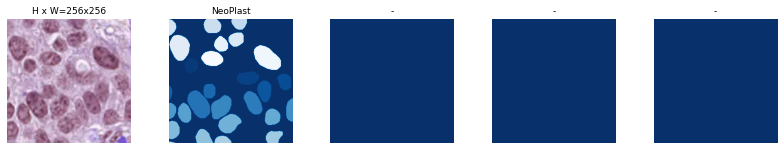

[INFO] investigating image index: 1497


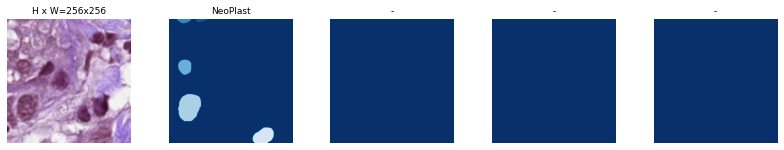

[INFO] investigating image index: 2917


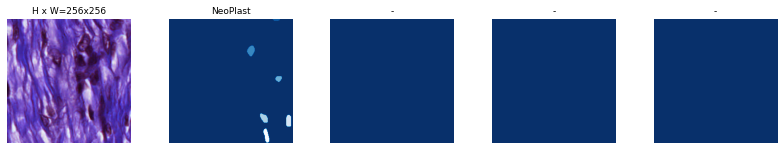

In [18]:
# check data and masks before training
trainDataset = NeoPlastDataset(exp_img_pathlist, CLASS_NAMES)
trainDataset.load_cells(trainIdxs)
trainDataset.prepare()

# load the 0-th training image and corresponding masks and
# class IDs in the masks
image = trainDataset.load_image(0)
(masks, classIDs) = trainDataset.load_mask(0)

# show the image spatial dimensions
print("image shape: {}".format(image.shape))

# show the masks shape which should have the same width and
# height of the images but the third dimension should be
# equal to the total number of instances in the image itself
print("masks shape: {}".format(masks.shape))

# show the length of the class IDs list along with the values
# inside the list
print("class IDs length: {}".format(len(classIDs)))
print("class IDs: {}".format(classIDs))

# determine a sample of training image indexes and loop over
# them
for i in np.random.choice(trainDataset.image_ids, 3):
    # load the image and masks for the sampled image
    print("[INFO] investigating image index: {}".format(i))
    image = trainDataset.load_image(i)
    (masks, classIDs) = trainDataset.load_mask(i)

    # visualize the masks for the current image
    visualize.display_top_masks(image, masks, classIDs,
                                        trainDataset.class_names)

### Training

In [14]:
# load training dataset
trainDataset = NeoPlastDataset(exp_img_pathlist, CLASS_NAMES)
trainDataset.load_cells(trainIdxs)
trainDataset.prepare()

# load the validation dataset
valDataset = NeoPlastDataset(exp_img_pathlist, CLASS_NAMES)
valDataset.load_cells(valIdxs)
valDataset.prepare()

# initialize the training configuration to check parameters
config = NeoPlastConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [15]:
# initialize the image augmentation process
aug = iaa.SomeOf((0, 2), [iaa.Fliplr(0.5),
                          iaa.Flipud(0.5),
                          iaa.Affine(rotate=(-10, 10))
                         ])

# initialize the model and put in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=LOGS_AND_MODEL_DIR)

# function to either resume training or start fresh a process
if model_weights=="new":
    # remove useless layers
    model.load_weights(COCO_PATH, by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                            "mrcnn_bbox", "mrcnn_mask"])
else:
    model.load_weights(model_path,
                  by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [16]:
# clean code to remove files if training starts fresh
if model_weights=="new":
    if os.path.exists("outs/training_plot.jpg"):
        os.remove("outs/training_plot.jpg")
    if os.path.exists("outs/training_values.json"):    
        os.remove("outs/training_values.json")
    if os.path.exists("outs/learning_rate.json"):    
        os.remove("outs/learning_rate.json")
    if os.path.exists("outs/loss_values.json"):
        os.remove("outs/loss_values.json")
    
# callback to monitor traning, decay lr and save model at intervals
custom_callbacks= [TrainMonitor(figPath="outs/training_plot.jpg",
                               jsonPath="outs/training_values.json",
                               startAt=initial_epoch),
                   LearningRateScheduler(poly_lr_decay)]

In [ ]:
# set previous lr from file
if model_weights=="new":
    lr_to_set= config.LEARNING_RATE
else:
    lr_dict= json.loads(open("outs/learning_rate.json").read())
    lr_to_set= lr_dict[list(lr_dict)[-1]]

# train only the network heads    
model.train(trainDataset, valDataset, epochs=int(max_epoch),
          layers="heads", learning_rate=lr_to_set, 
            custom_callbacks=custom_callbacks,
            augmentation= aug)

In [ ]:
lr_dict= json.loads(open("outs/learning_rate.json").read())
lr_to_set= lr_dict[list(lr_dict)[-1]]

# train entire model
model.train(trainDataset, valDataset, epochs=max_epoch,
            layers="all", learning_rate=lr_to_set,
            custom_callbacks=custom_callbacks,
            augmentation=aug)